In [23]:
import random
import matplotlib.pyplot as plt
import time

amountOfLocations = 50
locations = []
cars = 8
generations = 100
depot = (0, 0)
population_size = 10
mutation_rate = 0.5

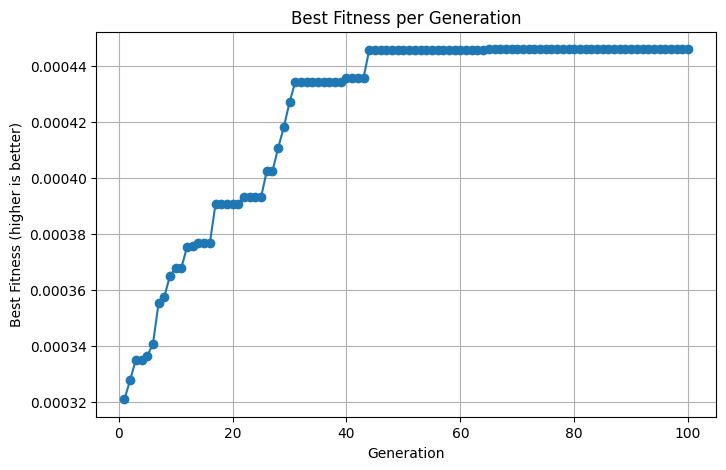

In [24]:
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(amountOfLocations)]

def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_vrp_cost_and_routes(individual, num_vehicles):
    n = len(individual)
    if n == 0:
        return float('inf'), []
    # Precompute distances between consecutive customers
    dist_seq = [distance(locations[individual[i]], locations[individual[(i+1) % n]]) for i in range(n)]
    prefix = [0] * (n + 1)
    for i in range(n):
        prefix[i+1] = prefix[i] + dist_seq[i]
    inf = float('inf')
    dp = [[inf] * (n + 1) for _ in range(num_vehicles + 1)]
    prev = [[-1] * (n + 1) for _ in range(num_vehicles + 1)]
    dp[0][0] = 0
    for m in range(1, num_vehicles + 1):
        for j in range(1, n + 1):
            for i in range(j):
                if j - i < 1:  # No empty routes
                    continue
                internal = prefix[j] - prefix[i]
                start_cust = locations[individual[i]]
                end_cust = locations[individual[j-1]]
                route_cost = distance(depot, start_cust) + internal + distance(end_cust, depot)
                new_cost = dp[m-1][i] + route_cost
                if new_cost < dp[m][j]:
                    dp[m][j] = new_cost
                    prev[m][j] = i
    total_distance = dp[num_vehicles][n]
    if total_distance == inf:
        return inf, []
    # Reconstruct routes
    routes = []
    m = num_vehicles
    j = n
    while j > 0:
        i = prev[m][j]
        if i == -1:
            return inf, []
        route = individual[i:j]
        routes.append(route)
        j = i
        m -= 1
    routes.reverse()
    return total_distance, routes

def fitness(individual):
    total_dist, _ = get_vrp_cost_and_routes(individual, cars)
    return 1 / total_dist if total_dist > 0 else 0

def create_individual():
    return random.sample(range(len(locations)), len(locations))

def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [-1] * len(parent1)
    child[start:end] = parent1[start:end]
    pointer = end
    for location in parent2:
        if location not in child:
            child[pointer] = location
            pointer = (pointer + 1) % len(child)
    return child

def mutate(individual):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def tournament_selection(population, k=3):
    contestants = random.sample(population, k)
    return max(contestants, key=fitness)

def visualize_individual(individual, fitness_value):
    total_dist, routes = get_vrp_cost_and_routes(individual, cars)
    route_str = "\n".join([f"Vehicle {r+1}: depot -> " + " -> ".join(map(str, route)) + " -> depot" for r, route in enumerate(routes)])
    return f"{route_str}\nTotal Distance: {total_dist:.2f} Fitness: {fitness_value:.6f}"

def genetic_algorithm_with_tracking():
    population = [create_individual() for _ in range(population_size)]
    best_fitness_per_gen = []
    elite_size = 1  # Adjust as needed, e.g., int(0.1 * population_size)
    
    for generation in range(generations):
        fitnesses = [fitness(ind) for ind in population]
        best_fitness = max(fitnesses)
        best_fitness_per_gen.append(best_fitness)
        
        # Find elites: Sort population by fitness descending and take top elite_size
        sorted_pop = sorted(population, key=fitness, reverse=True)
        elites = [ind[:] for ind in sorted_pop[:elite_size]]  # Copy to avoid mutation
        
        new_population = []
        # Generate fewer offspring to accommodate elites
        for _ in range((population_size - elite_size) // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        
        # Add elites to new population
        new_population.extend(elites)
        
        population = new_population
    return best_fitness_per_gen

best_fitness_per_gen = genetic_algorithm_with_tracking()
plt.figure(figsize=(8, 5))
plt.plot(range(1, generations+1), best_fitness_per_gen, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (higher is better)')
plt.title('Best Fitness per Generation')
plt.grid(True)
plt.show()